<a href="https://colab.research.google.com/github/gustvjor2005/cat-detection-cnn/blob/fullcomment/cat_detection_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import h5py
import numpy as np

torch.manual_seed(2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
#wget utilitario gnu para recupear documentos de forma no interactiva
#soporta http, https y ftp | -O para recuperar con un nombre de archivo fijo 
#esto ayuda a sobreescribir cuando el archivo ya existe
!cd sample_data && wget -O train_catvnoncat.h5 http://gchoque.de:8989/train_catvnoncat.h5
!cd sample_data && wget -O test_catvnoncat.h5 http://gchoque.de:8989/test_catvnoncat.h5

In [181]:
train_dataset = h5py.File("/content/sample_data/train_catvnoncat.h5")
test_dataset = h5py.File("/content/sample_data/test_catvnoncat.h5")

In [182]:
tr_x = np.array(train_dataset["train_set_x"])
tr_y = np.array(train_dataset["train_set_y"])

ts_x = np.array(test_dataset["test_set_x"])
ts_y = np.array(test_dataset["test_set_y"])

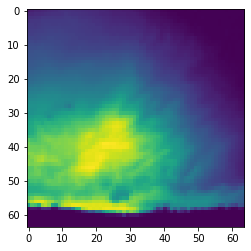

In [127]:
import matplotlib.pyplot as plt
#fig , ax = plt.subplots()
plt.imshow(tr_x[0][:, :, 0])

In [183]:

def shapeImage(xx):

  r = xx[0][:, :, 0]
  b = xx[0][:, :, 2]
  g = xx[0][:, :, 1]
  rr = r.reshape((-1, 64, 64))
  gg = g.reshape((-1, 64, 64))
  bb = b.reshape((-1, 64, 64))
  cc = np.append(rr, gg, axis=0)
  c = np.append(cc, bb, axis=0)

  for i in range(xx.shape[0]-1):
    r = xx[i+1][:, :, 0]
    g = xx[i+1][:, :, 1]
    b = xx[i+1][:, :, 2]
    rr = r.reshape((-1, 64, 64))
    gg = g.reshape((-1, 64, 64))
    bb = b.reshape((-1, 64, 64))
    dd = np.append(rr, gg, axis=0)
    d = np.append(dd, bb, axis=0)

    z = np.append(c.reshape(-1, 3, 64, 64), d.reshape(-1, 3, 64, 64), axis=0)
    c = z

  return z

In [184]:
tr_xx = shapeImage(tr_x)/255
ts_xx = shapeImage(ts_x)/255

In [185]:
ts_xx.shape

(50, 3, 64, 64)

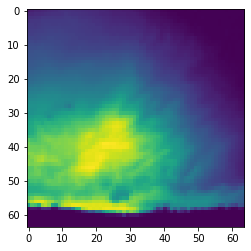

In [135]:
plt.imshow(tr_x[0][:, :, 0])

In [186]:
class Dataset(Dataset):

  def __init__(self):
    #self.x = torch.tensor(tr_x, dtype=torch.float).view(-1, 3, 64, 64)
    self.x = torch.tensor(tr_xx, dtype=torch.float)
    #self.y = torch.tensor(tr_y, dtype=torch.float).view(self.x.size()[0], 1)
    self.y = torch.tensor(tr_y)
    self.len = self.x.size()[0]

  def __getitem__(self, index):
    return self.x[index], self.y[index]

  def __len__(self):
    return self.len


In [201]:
class CNN(nn.Module):

  def __init__(self, out_1=5, out_2=7):
    super().__init__()
    self.cnn1 = nn.Conv2d(in_channels=3, out_channels=out_1, kernel_size=5)
    #l ->64 -5 + 1 = 60 | cnn1.weight.shape -> 5x3x5x5
    self.maxpool1 = nn.MaxPool2d(kernel_size=2)
    #l ->60/2 = 30
    self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5)
    #l ->30 -5 +1 = 26 | cnn2.weight.shape -> 7x5x5x5
    self.maxpool2 = nn.MaxPool2d(kernel_size=2)
    #l ->26/2 = 13
    self.fc1 = nn.Linear(out_2*13*13, 2)  # fc1.weight.shape -> 1x7*13*13

  def forward(self, x):
    x = self.cnn1(x)
    #print('after cnn1', x.shape)
    x = torch.relu(x) #activation function
    #print('after relu', x.shape)
    x = self.maxpool1(x)
    #print('after maxpool1', x.shape)
    x = self.cnn2(x)
    #print('after cnn2', x.shape)
    x = torch.relu(x) #activation function
    #print('after relu', x.shape)
    x = self.maxpool2(x)
    #print('after maxpool2', x.shape)
    x = x.view(x.size(0), -1)
    #print('after size', x.shape)
    x = self.fc1(x)
    #print('after fc1', x)
    #x = torch.sigmoid(x)
    #print('after sigmoid', x)
    return x

In [202]:
class CNN_2(nn.Module):

  def __init__(self, out_1=5, out_2=7, out_3=9):
    super().__init__()
    self.cnn1 = nn.Conv2d(in_channels=3, out_channels=out_1, kernel_size=5)
    #l ->64 -5 + 1 = 60 | cnn1.weight.shape -> 5x3x5x5
    self.maxpool1 = nn.MaxPool2d(kernel_size=2)
    #l ->60/2 = 30
    self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5)
    #l ->30 -5 +1 = 26 | cnn2.weight.shape -> 7x5x5x5
    self.maxpool2 = nn.MaxPool2d(kernel_size=2)
    #l ->26/2 = 13
    self.cnn3 = nn.Conv2d(in_channels=out_2, out_channels=out_3, kernel_size=8)
    #l = 13 - 8 +1 =6 
    self.maxpool3 = nn.MaxPool2d(kernel_size=2)
    #l ->6/2 = 3
    self.fc1 = nn.Linear(out_3*3*3, 2)  #

  def forward(self, x):
    x = self.cnn1(x)
    #print('after cnn1', x.shape)
    x = torch.relu(x) #activation function
    #print('after relu', x.shape)
    x = self.maxpool1(x)
    #print('after maxpool1', x.shape)
    x = self.cnn2(x)
    #print('after cnn2', x.shape)
    x = torch.relu(x) #activation function
    #print('after relu', x.shape)
    x = self.maxpool2(x)
    #print('after maxpool2', x.shape)
    
    #print('after size', x.shape)
    x = self.cnn3(x)
    x = torch.relu(x)
    x = self.maxpool3(x)
    x = x.view(x.size(0), -1)
    x = self.fc1(x)
    #print('after fc1', x)
    x = torch.sigmoid(x)
    #print('after sigmoid', x)
    return x

In [223]:
class CNN_3(nn.Module):

  def __init__(self, out_1=5, out_2=7):
    super().__init__()
    self.cnn1 = nn.Conv2d(in_channels=3, out_channels=out_1, kernel_size=15)
    #l ->64 -15 + 1 = 50 | cnn1.weight.shape -> 5x3x15x15
    self.maxpool1 = nn.MaxPool2d(kernel_size=2)
    #l ->50/2 = 25
    self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=16)
    #l ->25 -16 +1 = 10 | cnn2.weight.shape -> 7x5x16x16
    self.maxpool2 = nn.MaxPool2d(kernel_size=2)
    #l ->10/2 = 5
    self.fc1 = nn.Linear(out_2*5*5, 2)  # fc1.weight.shape -> 1x7x5x5

  def forward(self, x):
    x = self.cnn1(x)
    #print('after cnn1', x.shape)
    x = torch.relu(x) #activation function
    #print('after relu', x.shape)
    x = self.maxpool1(x)
    #print('after maxpool1', x.shape)
    x = self.cnn2(x)
    #print('after cnn2', x.shape)
    x = torch.relu(x) #activation function
    #print('after relu', x.shape)
    x = self.maxpool2(x)
    #print('after maxpool2', x.shape)
    x = x.view(x.size(0), -1)
    #print('after size', x.shape)
    x = self.fc1(x)
    #print('after fc1', x)
    #x = torch.sigmoid(x)
    #print('after sigmoid', x)
    return x

In [224]:
model = CNN_3(out_1=5, out_2=7)
model.state_dict()['fc1.weight'].shape

torch.Size([2, 175])

In [225]:
tr_dataset = Dataset()

tr_dataloader = DataLoader(dataset=tr_dataset, batch_size=30)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=.01)


In [ ]:
epochs = 3
losses = []
accs = []


for i in range(epochs):
  total = 0
  model.train()
  model.to(device)
  for x, y in tr_dataloader:
    x, y = x.to(device), y.to(device)
    yhat = model(x)
    loss = criterion(yhat, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total += loss.item()

  acc = 0
  model.eval()
  model.to('cpu')
  val = torch.tensor(ts_xx, dtype=torch.float)
  for x, y in zip(val, ts_y):
    pred = model(x.view(1, 3, 64, 64))
    print(pred)
    if (pred.argmax().item() == y):
      acc +=1
  losses.append(total)
  accs.append(acc)
  #print(acc/ts_xx.size(0)*100)

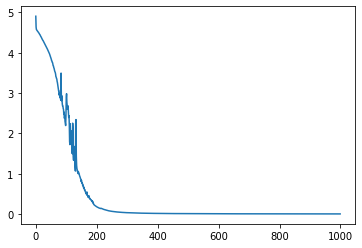

In [227]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.show()

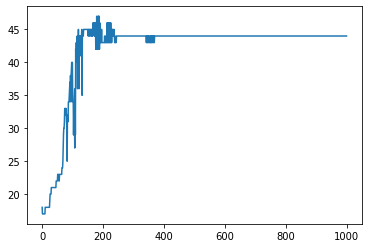

In [228]:
plt.plot(accs)
plt.show()

In [240]:
import PIL.Image as img

In [255]:
!cd sample_data && wget -O cat1.png http://gchoque.de:8989/cat2.png

--2023-03-16 22:21:45--  http://gchoque.de:8989/cat2.png
Resolving gchoque.de (gchoque.de)... 15.229.12.247
Connecting to gchoque.de (gchoque.de)|15.229.12.247|:8989... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9834 (9.6K) [image/png]
Saving to: ‘cat1.png’

cat1.png            100%[===================>]   9.60K  --.-KB/s    in 0s      

2023-03-16 22:21:45 (156 MB/s) - ‘cat1.png’ saved [9834/9834]



In [256]:
img_o = img.open("/content/sample_data/cat1.png")

img_n = np.asarray(img_o)
img_n.shape
#img_s = img_n.reshape(3, 64, 64)


(64, 64, 4)

In [270]:
r = img_n[:, :, 0].reshape(-1, 64, 64)
g = img_n[:, :, 1].reshape(-1, 64, 64)
b = img_n[:, :, 2].reshape(-1, 64, 64)

img_s = np.append(r, g, axis=0)
img_s = np.append(img_s, b, axis=0)

z = img_n[:, :, 0:3]

z.shape

(64, 64, 3)

In [273]:
data_test = np.array([z,z])
data_test.shape

(2, 64, 64, 3)

In [274]:
tr_zz = shapeImage(data_test)/255

In [275]:
tr_zz.shape

(2, 3, 64, 64)

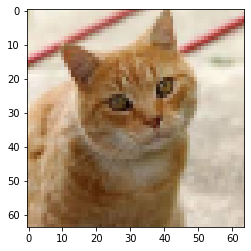

In [271]:
plt.imshow(z)

In [279]:
pred = model(torch.tensor(tr_zz,dtype=torch.float))

In [280]:
pred

tensor([[-2.1045,  3.3893],
        [-2.1045,  3.3893]], grad_fn=<AddmmBackward0>)